 ## Forecasting Individual Household Electric Power Consumption

In [2]:
import pandas as pd
df = pd.read_csv('/content/household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')
print(df.head())

<ipython-input-2-3abb3f6a70a6>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/content/household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')
<ipython-input-2-3abb3f6a70a6>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/content/household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')


                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [4]:
df.shape

(2075259, 7)

In [5]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

**Question 11 - 14**

In [6]:
df.fillna(method='ffill', inplace=True)
df_hourly = df.resample('H').sum()

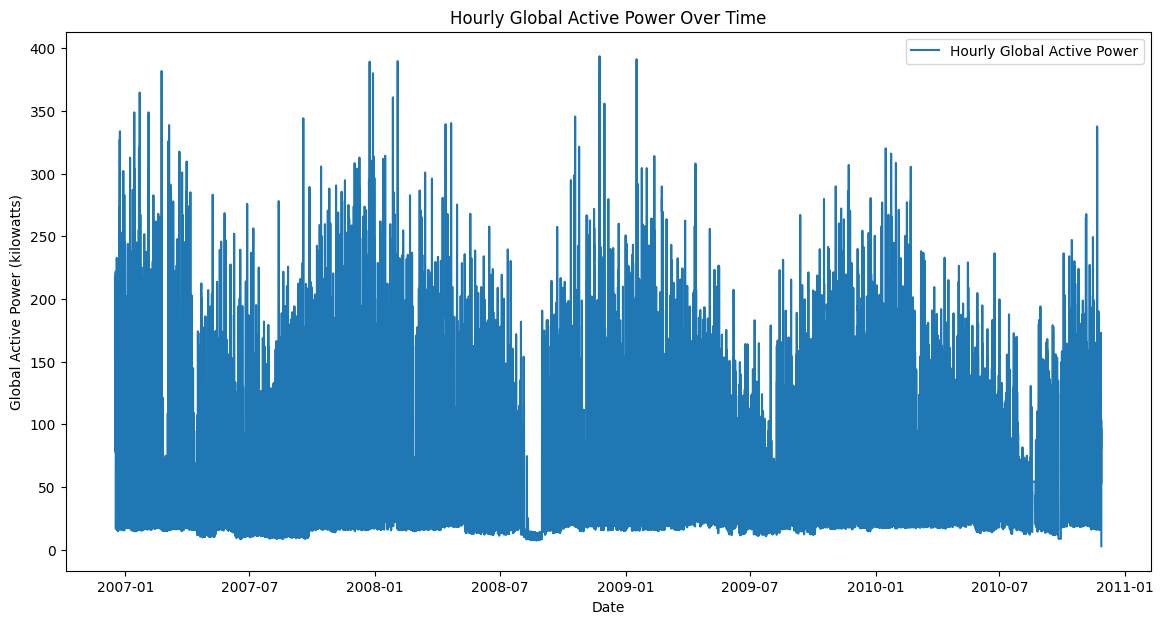

In [7]:
import matplotlib.pyplot as plt

# Plot the hourly global_active_power over time
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Hourly Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Hourly Global Active Power Over Time')
plt.legend()
plt.show()

In [8]:
correlation_coefficient = df['Global_active_power'].corr(df['Voltage'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.39564658423499544


In [9]:
correlation_coefficient = df['Voltage'].corr(df['Global_intensity'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.40745369921886454


**Question 14 - 16**

In [10]:
# Resample data to daily consumption
df_daily = df['Global_active_power'].resample('D').sum().reset_index()

# Rename columns to match Prophet requirements
df_daily.columns = ['ds', 'y']

In [11]:
df_daily

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748
...,...,...
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164


In [12]:
# Define the test set size
test_size = 300
train_size = len(df_daily) - test_size

# Split data into train and test sets
train = df_daily.iloc[:train_size]
test = df_daily.iloc[train_size:]

In [13]:
test

,ds,y
1142,2010-01-31,1799.196
1143,2010-02-01,1693.778
1144,2010-02-02,2157.432
1145,2010-02-03,2903.014
1146,2010-02-04,2316.270
...,...,...
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164


In [14]:
from prophet import Prophet

# Initialize and train the model
prophet_model = Prophet()
prophet_model.fit(train)

# Make predictions
future = prophet_model.make_future_dataframe(periods=test_size)
forecast = prophet_model.predict(future)
forecast.head()

# Extract the forecasted values
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').loc[test['ds']]

# Combine actual and predicted values for comparison
comparison = test.set_index('ds').join(prophet_forecast)

comparison.columns = ['y', 'yhat']
comparison.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpda9bbva5/_ih48grc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpda9bbva5/1qopdhhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45615', 'data', 'file=/tmp/tmpda9bbva5/_ih48grc.json', 'init=/tmp/tmpda9bbva5/1qopdhhr.json', 'output', 'file=/tmp/tmpda9bbva5/prophet_modelkkbdkxdg/prophet_model-20240618123838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:38:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,y,yhat
ds,,
2010-01-31,1799.196,2432.237708
2010-02-01,1693.778,2056.789680
2010-02-02,2157.432,2193.262581
2010-02-03,2903.014,2187.598834
2010-02-04,2316.270,2006.677420


Question 14

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
mse = mean_squared_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 295.3780195111622
Mean Squared Error (MSE): 161289.4065673645
Root Mean Squared Error (RMSE): 401.6085240222927
Mean Absolute Percentage Error (MAPE): 0.27202153400074175


**MAPE is 27.2%**

Question 15

**RMSE is 401.61**

Question 16

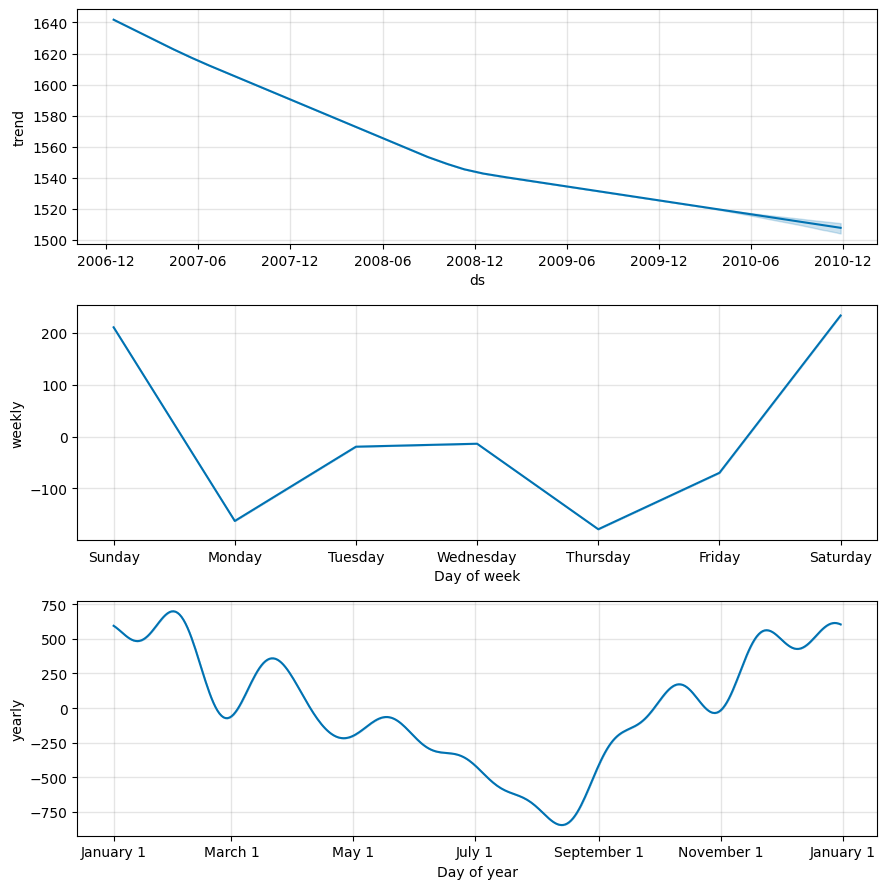

In [16]:
# Plot trend and seasonal components
prophet_model.plot_components(forecast)
plt.show()

**Thursday** is the day of the week with the lowest value

**Question 17 - 20**

In [17]:
# Resample data to daily consumption
df_multi_daily = df.resample('D').sum().reset_index()

# Rename columns to match Prophet requirements
df_multi_daily.columns = ['ds', 'y', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6']

In [18]:
# Define the test set size
test_size = 300
train_size = len(df_daily) - test_size

# Split data into train and test sets
train_multi = df_multi_daily.iloc[:train_size]
test_multi = df_multi_daily.iloc[train_size:]

In [19]:
# Initialize the model
prophet_model = Prophet()

# Add the additional regressors
prophet_model.add_regressor('add1')
prophet_model.add_regressor('add2')
prophet_model.add_regressor('add3')
prophet_model.add_regressor('add4')
prophet_model.add_regressor('add5')
prophet_model.add_regressor('add6')

# Fit the model
prophet_model.fit(train_multi)

# Make predictions
future = prophet_model.make_future_dataframe(periods=test_size)
future = future.merge(df_multi_daily.drop(columns=['y']), on='ds', how='left')
forecast = prophet_model.predict(future)

# Extract the forecasted values
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').loc[test_multi['ds']]

# Combine actual and predicted values for comparison
comparison = test_multi.set_index('ds').join(prophet_forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpda9bbva5/_rkl81mp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpda9bbva5/g5fpgcrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81415', 'data', 'file=/tmp/tmpda9bbva5/_rkl81mp.json', 'init=/tmp/tmpda9bbva5/g5fpgcrx.json', 'output', 'file=/tmp/tmpda9bbva5/prophet_modelpr_z66or/prophet_model-20240618124805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
# Calculate evaluation metrics
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
mse = mean_squared_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 30.906589776272508
Mean Squared Error (MSE): 1144.3998702354143
Root Mean Squared Error (RMSE): 33.82897973979431
Mean Absolute Percentage Error (MAPE): 0.02489902478784296


Question 17

**MAPE is 2.49%**

Question 18

**RMSE is 33.83**

Question 19

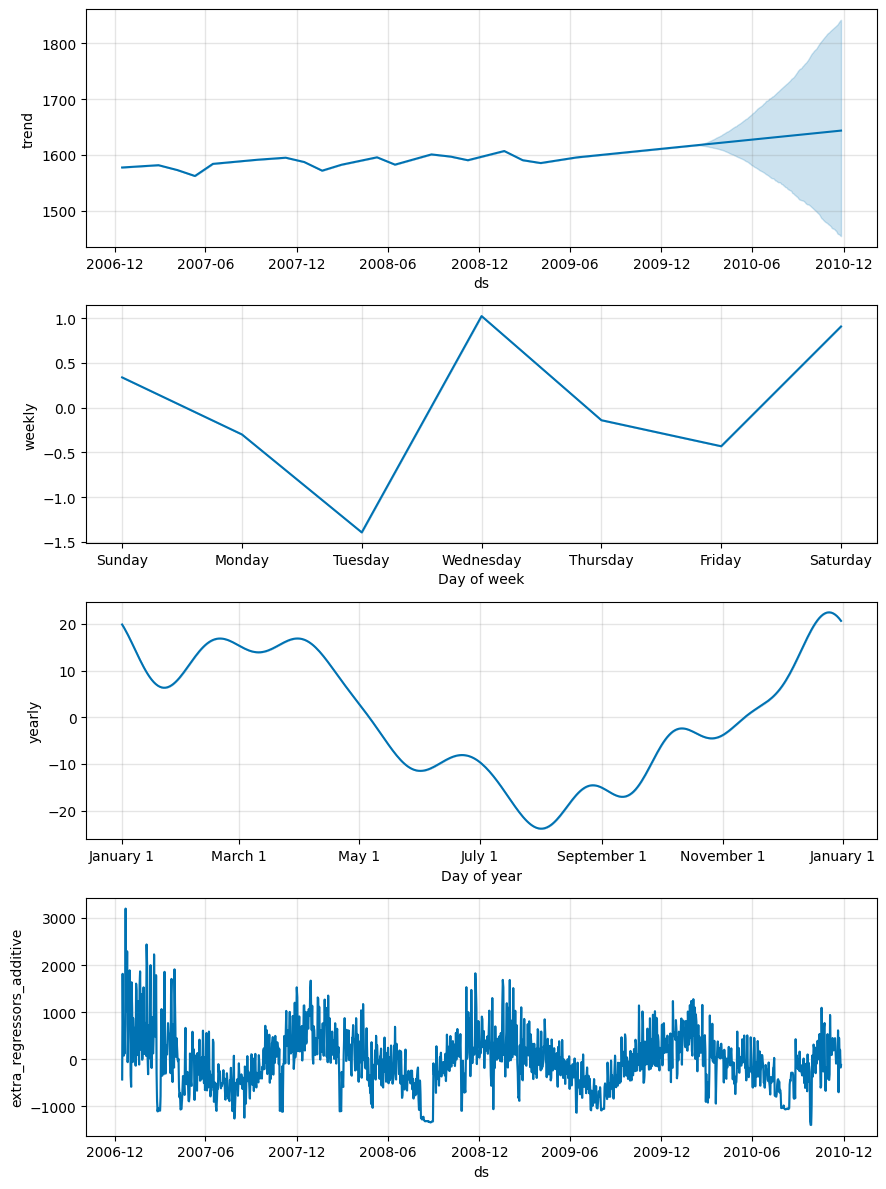

In [21]:
# Plot trend and seasonal components
prophet_model.plot_components(forecast)
plt.show()

The Day of the daily seasonality that has the lowet value is **Tuesday**

Question 20

The Month of the yearly seasonality that has the lowet value is **August**